# EDA


## Library Imports

In [514]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

import time

## Data Imports

In [121]:
#train data
data = pd.read_csv('../raw_data/dengue_features_train.csv')
labels = pd.read_csv('../raw_data/dengue_labels_train.csv')
data = data.merge(labels)
print(data.shape)

#test data
test_data = pd.read_csv('../raw_data/dengue_features_test.csv')
print(test_data.shape)

(1456, 25)
(416, 24)


In [122]:
data

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,5
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,8
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,1
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0,1


## Functions

In [123]:
def reg_metrics(y_train, y_train_pred, y_test, y_test_pred, model='model'):
    test_mae = metrics.mean_absolute_error(y_test, y_test_pred, multioutput='raw_values')
    train_mae = metrics.mean_absolute_error(y_train, y_train_pred, multioutput='raw_values')
    metrics_df = pd.DataFrame(data = zip(test_mae, train_mae),
                              columns=['test_mae','train_mae'])
    metrics_df.index.names = [model]
    return metrics_df

## Basic data preparation and visualizations

In [124]:
#NaN count for each column
data.isnull().sum().sort_values(ascending=False)

ndvi_ne                                  194
ndvi_nw                                   52
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_precip_mm                         22
ndvi_se                                   22
ndvi_sw                                   22
station_max_temp_c                        20
station_min_temp_c                        14
precipitation_amt_mm                      13
reanalysis_sat_precip_amt_mm              13
reanalysis_relative_humidity_percent      10
reanalysis_tdtr_k                         10
reanalysis_specific_humidity_g_per_kg     10
reanalysis_max_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_min_air_temp_k                 10
reanalysis_dew_point_temp_k               10
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
city                                       0
year                                       0
week_start

These Nan values will be tackled in preprocessing

### Splitting data into separate dataframes for both cities

In [836]:
data_sj = data.iloc[:936,:]

In [837]:
data_iq = data.iloc[936:,:]

In [838]:
print(data_iq.shape,data_sj.shape)

(520, 25) (936, 25)


In [804]:
#fix time data
data_iq['year_week'] = pd.to_datetime(data_iq['week_start_date']).dt.strftime('%Y-%U')
data_iq['week'] = pd.to_datetime(data_iq['week_start_date']).dt.strftime('%U')
data_iq['month'] = pd.DatetimeIndex(data_iq['week_start_date']).month

data_sj['year_week'] = pd.to_datetime(data_sj['week_start_date']).dt.strftime('%Y-%U')
data_sj['week'] = pd.to_datetime(data_sj['week_start_date']).dt.strftime('%U')
data_sj['month'] = pd.DatetimeIndex(data_sj['week_start_date']).month

/var/folders/32/ctcz3rj15jg1r9xjzn1p08p40000gn/T/ipykernel_99638/611139066.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sj['year_week'] = pd.to_datetime(data_sj['week_start_date']).dt.strftime('%Y-%U')
/var/folders/32/ctcz3rj15jg1r9xjzn1p08p40000gn/T/ipykernel_99638/611139066.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sj['week'] = pd.to_datetime(data_sj['week_start_date']).dt.strftime('%U')
/var/folders/32/ctcz3rj15jg1r9xjzn1p08p40000gn/T/ipykernel_99638/611139066.py:8: SettingWith

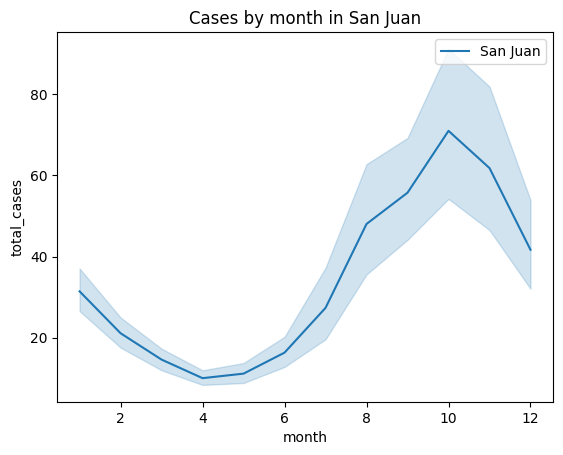

In [805]:
plt.title('Cases by month in San Juan')
sns.lineplot(data=data_sj,x='month',y='total_cases',label='San Juan')
plt.show;

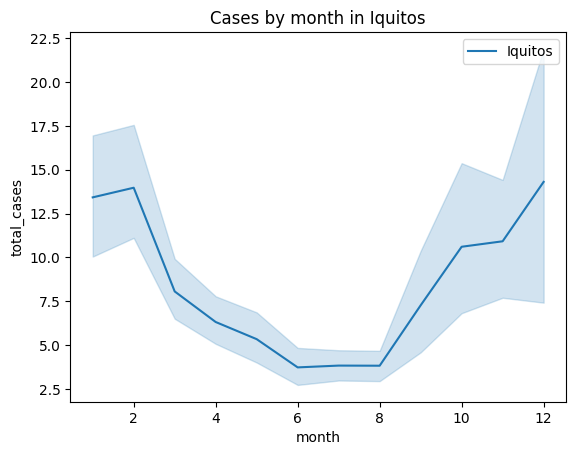

In [806]:
plt.title('Cases by month in Iquitos')
sns.lineplot(data=data_iq,x='month',y='total_cases',label='Iquitos')
plt.show;

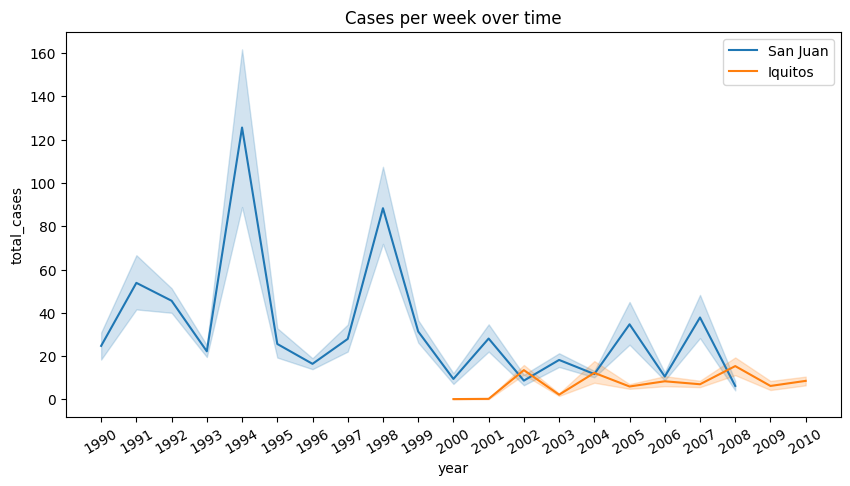

In [839]:
plt.figure(figsize=(10, 5))
plt.title('Cases per week over time')
sns.lineplot(data=data_sj,x='year',y='total_cases',label='San Juan')
sns.lineplot(data=data_iq,x='year',y='total_cases',label='Iquitos')
plt.xticks(np.arange(1990, 2011, step=1),rotation=30)
plt.legend()
plt.show;

## Preprocessing

In [840]:
def preprocess(rawfeats,train=True):
    
    #reset index to prevent issues when merging
    reindexed_data = rawfeats.reset_index(drop = True)
    
    #fill nas with interpolation
    feats = reindexed_data.interpolate(method='linear')
    
    new_columns = pd.DataFrame()
    #scale and average total precipitation
    precipitation_to_avg = feats.loc[:,['reanalysis_sat_precip_amt_mm','precipitation_amt_mm','station_precip_mm','reanalysis_precip_amt_kg_per_m2']]
    scaled_precip = pd.DataFrame(MinMaxScaler().fit_transform(precipitation_to_avg), 
                                columns=precipitation_to_avg.columns)
    new_columns.loc[:,'avg_total_precipitation'] = scaled_precip.mean(axis=1)
    
    #scale and average temperature
    temps_to_avg = feats.loc[:,['reanalysis_air_temp_k','reanalysis_avg_temp_k','station_avg_temp_c']]
    scaled_temps = pd.DataFrame(MinMaxScaler().fit_transform(temps_to_avg), 
                                columns=temps_to_avg.columns)
    new_columns.loc[:,'avg_temp'] = scaled_temps.mean(axis=1)
    
    #scale and average max temperature
    max_temps_to_avg = feats.loc[:,['station_max_temp_c','reanalysis_max_air_temp_k']]
    scaled_max_temps = pd.DataFrame(MinMaxScaler().fit_transform(max_temps_to_avg), 
                                columns=max_temps_to_avg.columns)
    new_columns.loc[:,'avg_max_temp'] = scaled_max_temps.mean(axis=1)
    
    #scale and average min temperature
    min_temps_to_avg = feats.loc[:,['station_min_temp_c','reanalysis_min_air_temp_k']]
    scaled_min_temps = pd.DataFrame(MinMaxScaler().fit_transform(min_temps_to_avg), 
                                columns=min_temps_to_avg.columns)
    new_columns.loc[:,'avg_min_temp'] = scaled_min_temps.mean(axis=1)
    
    #scale and average diurnal temperature
    diurnal_temps_to_avg = feats.loc[:,['station_diur_temp_rng_c','reanalysis_tdtr_k']]
    scaled_diurnal_temps = pd.DataFrame(MinMaxScaler().fit_transform(diurnal_temps_to_avg), 
                                columns=diurnal_temps_to_avg.columns)
    new_columns.loc[:,'avg_diurnal_temp'] = scaled_diurnal_temps.mean(axis=1)
    
    #scale humidity and dew point data
    remaining_feats_to_scale = feats.loc[:,['reanalysis_specific_humidity_g_per_kg','reanalysis_relative_humidity_percent','reanalysis_dew_point_temp_k']]
    scaled_feats = pd.DataFrame(MinMaxScaler().fit_transform(remaining_feats_to_scale), 
                                columns=remaining_feats_to_scale.columns)
    
    df = new_columns.join(scaled_feats)
    
    #add shifted features, 4 weeks
    to_shift = ['avg_max_temp','reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg','avg_total_precipitation','reanalysis_dew_point_temp_k','avg_min_temp'] 
    for i in to_shift:
        df[i+'_1lag'] = df[i].shift(-1)
        df[i+'_2lag'] = df[i].shift(-2)
        df[i+'_3lag'] = df[i].shift(-3)
        df[i+'_4lag'] = df[i].shift(-4)
    df = df.fillna(method='ffill')
    
    #merge back together

    if train:
        non_scaled_feats = feats[['ndvi_ne', 'ndvi_nw',
           'ndvi_se', 'ndvi_sw','total_cases']]
    
    else:
        non_scaled_feats = feats[['ndvi_ne', 'ndvi_nw',
           'ndvi_se', 'ndvi_sw']]
    
    final_df = df.join(non_scaled_feats)
    
    return final_df

In [609]:
#backup preproc

# def preprocess_iq(rawfeats,train=True):
    
#     non_scaled_feats = rawfeats[['ndvi_ne', 'ndvi_nw',
#        'ndvi_se', 'ndvi_sw','total_cases']]
    
#     #fill nas with interpolation
#     feats = rawfeats.interpolate(method='linear')
    
#     #scale feats
#     remaining_feats_to_scale = feats.loc[:,['precipitation_amt_mm', 'reanalysis_air_temp_k',
#        'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
#        'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
#        'reanalysis_precip_amt_kg_per_m2',
#        'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
#        'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
#        'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
#        'station_min_temp_c', 'station_precip_mm']]
#     scaled_feats = pd.DataFrame(MinMaxScaler().fit_transform(remaining_feats_to_scale), 
#                                 columns=remaining_feats_to_scale.columns)
    
#     #add shifted features, 3 weeks
#     to_shift = ['reanalysis_min_air_temp_k','station_max_temp_c','reanalysis_relative_humidity_percent',
#        'reanalysis_specific_humidity_g_per_kg','reanalysis_precip_amt_kg_per_m2','reanalysis_dew_point_temp_k'] 
#     for i in to_shift:
#         scaled_feats[i+'_1lag'] = scaled_feats[i].shift(-1)
#         scaled_feats[i+'_2lag'] = scaled_feats[i].shift(-2)
#         scaled_feats[i+'_3lag'] = scaled_feats[i].shift(-3)
#         scaled_feats[i+'_4lag'] = scaled_feats[i].shift(-4)
#     scaled_feats = scaled_feats.fillna(method='ffill')
    
#     #merge back together
#     df = scaled_feats.join(non_scaled_feats)
    
#     return df

In [841]:
iq_data = preprocess(data_iq)
sj_data = preprocess(data_sj)
iq_data

,avg_total_precipitation,avg_temp,avg_max_temp,avg_min_temp,avg_diurnal_temp,reanalysis_specific_humidity_g_per_kg,reanalysis_relative_humidity_percent,reanalysis_dew_point_temp_k,avg_max_temp_1lag,avg_max_temp_2lag,...,reanalysis_dew_point_temp_k_4lag,avg_min_temp_1lag,avg_min_temp_2lag,avg_min_temp_3lag,avg_min_temp_4lag,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,total_cases
0,0.091467,0.425044,0.359888,0.656449,0.474689,0.543713,0.848334,0.609431,0.396871,0.280549,...,0.462669,0.551822,0.628976,0.093407,0.484326,0.192886,0.132257,0.340886,0.247200,0
1,0.201091,0.436853,0.396871,0.551822,0.568296,0.569033,0.876820,0.630275,0.280549,0.186423,...,0.195797,0.628976,0.093407,0.484326,0.208965,0.216833,0.276100,0.289457,0.241657,0
2,0.193929,0.379938,0.280549,0.628976,0.444669,0.599829,0.932356,0.661883,0.186423,0.382231,...,0.446438,0.093407,0.484326,0.208965,0.559398,0.176757,0.173129,0.204114,0.128014,0
3,0.043631,0.244600,0.186423,0.093407,0.470830,0.277844,0.721340,0.323936,0.382231,0.299941,...,0.466940,0.484326,0.208965,0.559398,0.508560,0.227729,0.145429,0.254200,0.200314,0
4,0.172640,0.383736,0.382231,0.484326,0.531145,0.399145,0.744051,0.462669,0.299941,0.475443,...,0.336750,0.208965,0.559398,0.508560,0.468074,0.328643,0.322129,0.254371,0.361043,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,0.174647,0.724049,0.565437,0.822846,0.564710,0.763388,0.758854,0.805741,0.493654,0.283205,...,0.683923,0.643146,0.539040,0.606304,0.691440,0.342750,0.318900,0.256343,0.292514,5
516,0.364925,0.576497,0.493654,0.643146,0.402552,0.713601,0.828282,0.761148,0.283205,0.263312,...,0.683923,0.539040,0.606304,0.691440,0.691440,0.160157,0.160371,0.136043,0.225657,8
517,0.178128,0.311833,0.283205,0.539040,0.233901,0.586484,0.893932,0.647360,0.263312,0.427332,...,0.683923,0.606304,0.691440,0.691440,0.691440,0.247057,0.146057,0.250357,0.233714,1
518,0.191917,0.333475,0.263312,0.606304,0.335460,0.563388,0.903240,0.626175,0.427332,0.427332,...,0.683923,0.691440,0.691440,0.691440,0.691440,0.333914,0.245771,0.278886,0.325486,1


In [842]:
print(iq_data.shape,sj_data.shape)

(520, 37) (936, 37)


## A look at correlations

In [810]:
# compute the correlations
sj_correlations = sj_data.corr()
iq_correlations = iq_data.corr()

Text(0.5, 1.0, 'San Juan Variable Correlations')

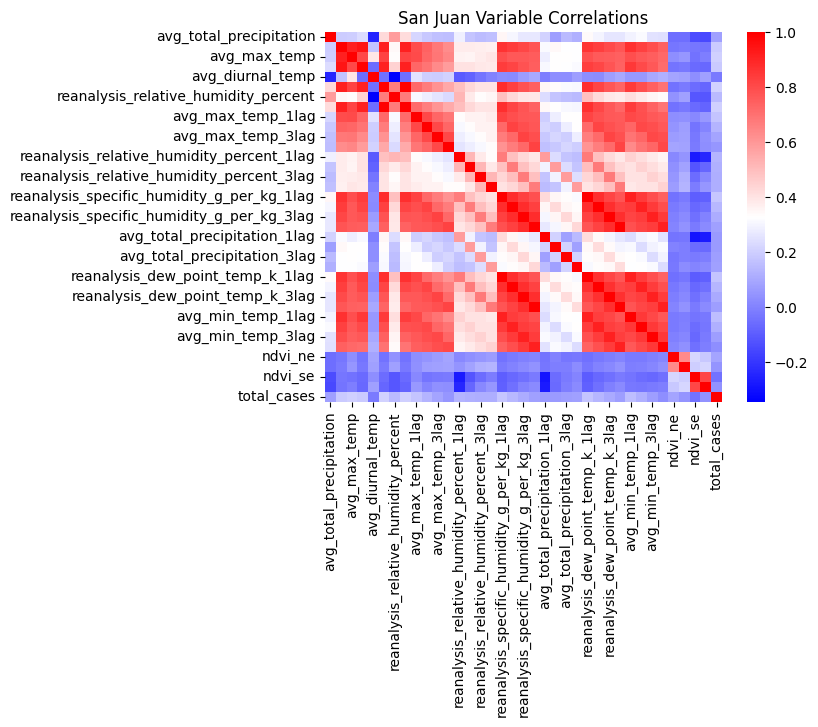

In [811]:
# plot san juan
sj_heatmap = sns.heatmap(sj_correlations,cmap= "bwr")
plt.title('San Juan Variable Correlations')

Text(0.5, 1.0, 'Iquitos Variable Correlations')

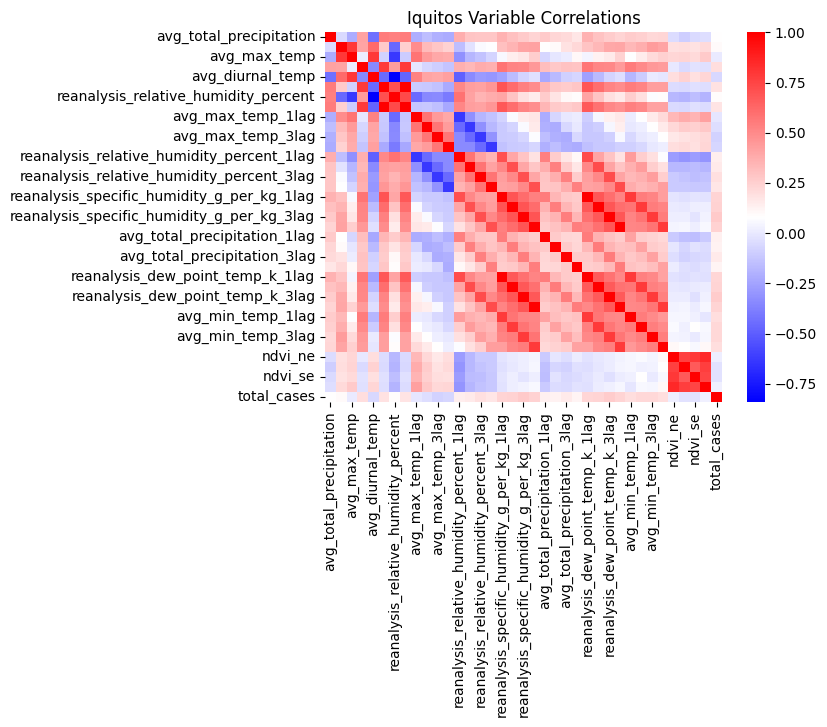

In [812]:
# plot iquitos
iq_corr_heat = sns.heatmap(iq_correlations,cmap= "bwr")
plt.title('Iquitos Variable Correlations')

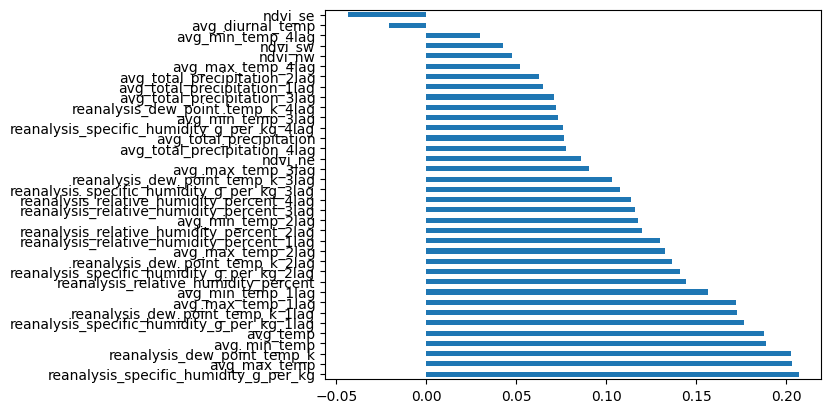

In [813]:
# San Juan
(sj_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh());

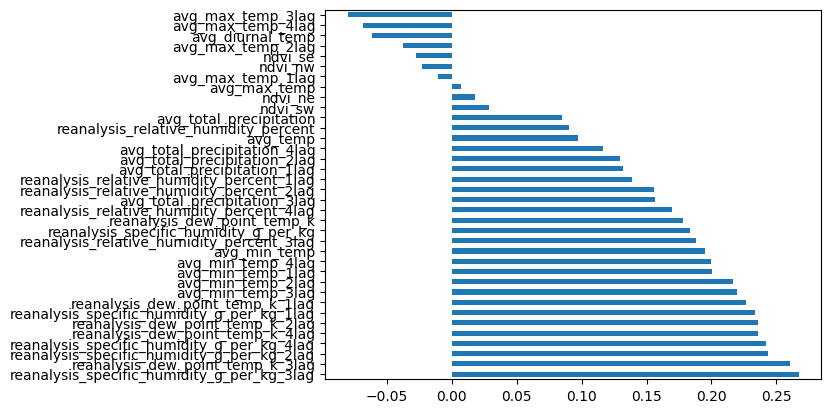

In [814]:
# Iquitos
(iq_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh());

## Baseline model to beat

In [815]:
#Baseline mae to beat for San Juan
abs(data_sj['total_cases']-(data_sj['total_cases'].mean())).mean()

28.352089268755936

In [816]:
#Baseline mae to beat for Iquitos
abs(data_iq['total_cases']-(data_iq['total_cases'].mean())).mean()

6.9153308128544415

## Modeling

In [843]:
iq_X = iq_data.drop(['total_cases'], axis=1)
iq_y = iq_data.total_cases

iq_X_train = iq_X.head(390)
iq_X_test = iq_X.tail(130)
iq_y_train = iq_y.head(390)
iq_y_test = iq_y.tail(130)

print(iq_X_train.shape)
print(iq_X_test.shape)

(390, 36)
(130, 36)


In [844]:
sj_X = sj_data.drop(['total_cases'], axis=1)
sj_y = sj_data.total_cases

sj_X_train = sj_X.head(702)
sj_X_test = sj_X.tail(234)
sj_y_train = sj_y.head(702)
sj_y_test = sj_y.tail(234)

print(sj_X_train.shape)
print(sj_X_test.shape)

(702, 36)
(234, 36)


### Random Forest

In [490]:
#Define the parameters we want to use for the Grid Search
param_grid = {
    'max_depth': [5,7,None],
    'warm_start': [True, False],
    'max_features': [4,5,6,7],
    'min_samples_leaf': [5,10,15],
    'min_samples_split': [2, 3],
    'n_estimators': [80,100,120],
}

In [464]:
# #Grid Search SJ
# start = time.time()

# rf = RandomForestRegressor(criterion='absolute_error')
# search_rf = GridSearchCV(rf, param_grid=param_grid, 
#                               cv=TimeSeriesSplit(n_splits=5), n_jobs=2, verbose=2, scoring='neg_mean_absolute_error')
# search_rf.fit(sj_X, sj_y);
# sj_rf_params = search_rf.best_params_
# print(search_rf.best_score_)

# executionTime = (time.time() - start)
# print("Execution time:",
#       np.round(executionTime,2)," seconds")

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END max_depth=4, max_features=2, min_samples_leaf=15, min_samples_split=2, n_estimators=80, warm_start=True; total time=   0.2s
[CV] END max_depth=4, max_features=2, min_samples_leaf=15, min_samples_split=2, n_estimators=80, warm_start=True; total time=   0.4s
[CV] END max_depth=4, max_features=2, min_samples_leaf=15, min_samples_split=2, n_estimators=80, warm_start=False; total time=   0.1s
[CV] END max_depth=4, max_features=2, min_samples_leaf=15, min_samples_split=2, n_estimators=80, warm_start=False; total time=   0.2s
[CV] END max_depth=4, max_features=2, min_samples_leaf=15, min_samples_split=2, n_estimators=80, warm_start=False; total time=   0.3s
[CV] END max_depth=4, max_features=2, min_samples_leaf=15, min_samples_split=2, n_estimators=80, warm_start=False; total time=   0.6s
[CV] END max_depth=4, max_features=2, min_samples_leaf=15, min_samples_split=2, n_estimators=100, warm_start=True; total time=   0.7s


[CV] END max_depth=4, max_features=2, min_samples_leaf=15, min_samples_split=2, n_estimators=80, warm_start=True; total time=   0.1s
[CV] END max_depth=4, max_features=2, min_samples_leaf=15, min_samples_split=2, n_estimators=80, warm_start=True; total time=   0.3s
[CV] END max_depth=4, max_features=2, min_samples_leaf=15, min_samples_split=2, n_estimators=80, warm_start=True; total time=   0.5s
[CV] END max_depth=4, max_features=2, min_samples_leaf=15, min_samples_split=2, n_estimators=80, warm_start=False; total time=   0.4s
[CV] END max_depth=4, max_features=2, min_samples_leaf=15, min_samples_split=2, n_estimators=100, warm_start=True; total time=   0.2s
[CV] END max_depth=4, max_features=2, min_samples_leaf=15, min_samples_split=2, n_estimators=100, warm_start=True; total time=   0.2s
[CV] END max_depth=4, max_features=2, min_samples_leaf=15, min_samples_split=2, n_estimators=100, warm_start=True; total time=   0.8s
[CV] END max_depth=4, max_features=2, min_samples_leaf=15, min_sa

[CV] END max_depth=4, max_features=3, min_samples_leaf=15, min_samples_split=3, n_estimators=120, warm_start=True; total time=   0.5s
[CV] END max_depth=4, max_features=3, min_samples_leaf=15, min_samples_split=3, n_estimators=120, warm_start=True; total time=   1.0s
[CV] END max_depth=4, max_features=3, min_samples_leaf=15, min_samples_split=3, n_estimators=120, warm_start=False; total time=   0.7s
[CV] END max_depth=4, max_features=3, min_samples_leaf=17, min_samples_split=2, n_estimators=80, warm_start=True; total time=   0.1s
[CV] END max_depth=4, max_features=3, min_samples_leaf=17, min_samples_split=2, n_estimators=80, warm_start=True; total time=   0.2s
[CV] END max_depth=4, max_features=3, min_samples_leaf=17, min_samples_split=2, n_estimators=80, warm_start=True; total time=   0.3s
[CV] END max_depth=4, max_features=3, min_samples_leaf=17, min_samples_split=2, n_estimators=80, warm_start=True; total time=   0.6s
[CV] END max_depth=4, max_features=3, min_samples_leaf=17, min_sa

[CV] END max_depth=4, max_features=3, min_samples_leaf=17, min_samples_split=2, n_estimators=100, warm_start=False; total time=   0.2s
[CV] END max_depth=4, max_features=3, min_samples_leaf=17, min_samples_split=2, n_estimators=100, warm_start=False; total time=   0.3s
[CV] END max_depth=4, max_features=3, min_samples_leaf=17, min_samples_split=2, n_estimators=100, warm_start=False; total time=   0.4s
[CV] END max_depth=4, max_features=3, min_samples_leaf=17, min_samples_split=2, n_estimators=100, warm_start=False; total time=   0.8s
[CV] END max_depth=4, max_features=3, min_samples_leaf=17, min_samples_split=2, n_estimators=120, warm_start=True; total time=   0.5s
[CV] END max_depth=4, max_features=3, min_samples_leaf=17, min_samples_split=2, n_estimators=120, warm_start=True; total time=   1.2s
[CV] END max_depth=4, max_features=3, min_samples_leaf=17, min_samples_split=2, n_estimators=120, warm_start=False; total time=   0.7s
[CV] END max_depth=4, max_features=3, min_samples_leaf=17

[CV] END max_depth=4, max_features=4, min_samples_leaf=19, min_samples_split=2, n_estimators=80, warm_start=True; total time=   0.6s
[CV] END max_depth=4, max_features=4, min_samples_leaf=19, min_samples_split=2, n_estimators=80, warm_start=False; total time=   0.1s
[CV] END max_depth=4, max_features=4, min_samples_leaf=19, min_samples_split=2, n_estimators=80, warm_start=False; total time=   0.2s
[CV] END max_depth=4, max_features=4, min_samples_leaf=19, min_samples_split=2, n_estimators=80, warm_start=False; total time=   0.6s
[CV] END max_depth=4, max_features=4, min_samples_leaf=19, min_samples_split=2, n_estimators=100, warm_start=True; total time=   0.2s
[CV] END max_depth=4, max_features=4, min_samples_leaf=19, min_samples_split=2, n_estimators=100, warm_start=True; total time=   0.3s
[CV] END max_depth=4, max_features=4, min_samples_leaf=19, min_samples_split=2, n_estimators=100, warm_start=True; total time=   0.5s
[CV] END max_depth=4, max_features=4, min_samples_leaf=19, min_

[CV] END max_depth=4, max_features=4, min_samples_leaf=19, min_samples_split=2, n_estimators=100, warm_start=False; total time=   0.3s
[CV] END max_depth=4, max_features=4, min_samples_leaf=19, min_samples_split=2, n_estimators=100, warm_start=False; total time=   0.5s
[CV] END max_depth=4, max_features=4, min_samples_leaf=19, min_samples_split=2, n_estimators=100, warm_start=False; total time=   1.0s
[CV] END max_depth=4, max_features=4, min_samples_leaf=19, min_samples_split=2, n_estimators=120, warm_start=True; total time=   0.6s
[CV] END max_depth=4, max_features=4, min_samples_leaf=19, min_samples_split=2, n_estimators=120, warm_start=True; total time=   1.3s
[CV] END max_depth=4, max_features=4, min_samples_leaf=19, min_samples_split=2, n_estimators=120, warm_start=False; total time=   0.9s
[CV] END max_depth=4, max_features=4, min_samples_leaf=19, min_samples_split=3, n_estimators=80, warm_start=True; total time=   0.1s
[CV] END max_depth=4, max_features=4, min_samples_leaf=19, 

[CV] END max_depth=5, max_features=3, min_samples_leaf=15, min_samples_split=2, n_estimators=80, warm_start=True; total time=   0.1s
[CV] END max_depth=5, max_features=3, min_samples_leaf=15, min_samples_split=2, n_estimators=80, warm_start=True; total time=   0.2s
[CV] END max_depth=5, max_features=3, min_samples_leaf=15, min_samples_split=2, n_estimators=80, warm_start=True; total time=   0.3s
[CV] END max_depth=5, max_features=3, min_samples_leaf=15, min_samples_split=2, n_estimators=80, warm_start=True; total time=   0.8s
[CV] END max_depth=5, max_features=3, min_samples_leaf=15, min_samples_split=2, n_estimators=80, warm_start=False; total time=   0.5s
[CV] END max_depth=5, max_features=3, min_samples_leaf=15, min_samples_split=2, n_estimators=100, warm_start=True; total time=   0.2s
[CV] END max_depth=5, max_features=3, min_samples_leaf=15, min_samples_split=2, n_estimators=100, warm_start=True; total time=   0.3s
[CV] END max_depth=5, max_features=3, min_samples_leaf=15, min_sam

[CV] END max_depth=5, max_features=3, min_samples_leaf=15, min_samples_split=2, n_estimators=120, warm_start=False; total time=   0.2s
[CV] END max_depth=5, max_features=3, min_samples_leaf=15, min_samples_split=2, n_estimators=120, warm_start=False; total time=   0.3s
[CV] END max_depth=5, max_features=3, min_samples_leaf=15, min_samples_split=2, n_estimators=120, warm_start=False; total time=   0.5s
[CV] END max_depth=5, max_features=3, min_samples_leaf=15, min_samples_split=2, n_estimators=120, warm_start=False; total time=   1.0s
[CV] END max_depth=5, max_features=3, min_samples_leaf=15, min_samples_split=3, n_estimators=80, warm_start=True; total time=   0.5s
[CV] END max_depth=5, max_features=3, min_samples_leaf=15, min_samples_split=3, n_estimators=80, warm_start=False; total time=   0.1s
[CV] END max_depth=5, max_features=3, min_samples_leaf=15, min_samples_split=3, n_estimators=80, warm_start=False; total time=   0.2s
[CV] END max_depth=5, max_features=3, min_samples_leaf=15, 

[CV] END max_depth=5, max_features=4, min_samples_leaf=17, min_samples_split=2, n_estimators=80, warm_start=False; total time=   0.2s
[CV] END max_depth=5, max_features=4, min_samples_leaf=17, min_samples_split=2, n_estimators=80, warm_start=False; total time=   0.6s
[CV] END max_depth=5, max_features=4, min_samples_leaf=17, min_samples_split=2, n_estimators=100, warm_start=True; total time=   0.2s
[CV] END max_depth=5, max_features=4, min_samples_leaf=17, min_samples_split=2, n_estimators=100, warm_start=True; total time=   0.3s
[CV] END max_depth=5, max_features=4, min_samples_leaf=17, min_samples_split=2, n_estimators=100, warm_start=True; total time=   0.5s
[CV] END max_depth=5, max_features=4, min_samples_leaf=17, min_samples_split=2, n_estimators=100, warm_start=True; total time=   1.1s
[CV] END max_depth=5, max_features=4, min_samples_leaf=17, min_samples_split=2, n_estimators=100, warm_start=False; total time=   0.7s
[CV] END max_depth=5, max_features=4, min_samples_leaf=17, mi

[CV] END max_depth=5, max_features=4, min_samples_leaf=17, min_samples_split=2, n_estimators=120, warm_start=False; total time=   0.4s
[CV] END max_depth=5, max_features=4, min_samples_leaf=17, min_samples_split=2, n_estimators=120, warm_start=False; total time=   0.6s
[CV] END max_depth=5, max_features=4, min_samples_leaf=17, min_samples_split=2, n_estimators=120, warm_start=False; total time=   1.3s
[CV] END max_depth=5, max_features=4, min_samples_leaf=17, min_samples_split=3, n_estimators=80, warm_start=True; total time=   0.6s
[CV] END max_depth=5, max_features=4, min_samples_leaf=17, min_samples_split=3, n_estimators=80, warm_start=False; total time=   0.1s
[CV] END max_depth=5, max_features=4, min_samples_leaf=17, min_samples_split=3, n_estimators=80, warm_start=False; total time=   0.3s
[CV] END max_depth=5, max_features=4, min_samples_leaf=17, min_samples_split=3, n_estimators=80, warm_start=False; total time=   0.6s
[CV] END max_depth=5, max_features=4, min_samples_leaf=17, m

[CV] END max_depth=6, max_features=2, min_samples_leaf=19, min_samples_split=2, n_estimators=80, warm_start=False; total time=   0.3s
[CV] END max_depth=6, max_features=2, min_samples_leaf=19, min_samples_split=2, n_estimators=80, warm_start=False; total time=   0.7s
[CV] END max_depth=6, max_features=2, min_samples_leaf=19, min_samples_split=2, n_estimators=100, warm_start=True; total time=   0.2s
[CV] END max_depth=6, max_features=2, min_samples_leaf=19, min_samples_split=2, n_estimators=100, warm_start=True; total time=   0.2s
[CV] END max_depth=6, max_features=2, min_samples_leaf=19, min_samples_split=2, n_estimators=100, warm_start=True; total time=   0.9s
[CV] END max_depth=6, max_features=2, min_samples_leaf=19, min_samples_split=2, n_estimators=100, warm_start=False; total time=   0.5s
[CV] END max_depth=6, max_features=2, min_samples_leaf=19, min_samples_split=2, n_estimators=100, warm_start=False; total time=   0.4s
[CV] END max_depth=6, max_features=2, min_samples_leaf=19, m

[CV] END max_depth=6, max_features=2, min_samples_leaf=19, min_samples_split=3, n_estimators=80, warm_start=True; total time=   0.6s
[CV] END max_depth=6, max_features=2, min_samples_leaf=19, min_samples_split=3, n_estimators=80, warm_start=False; total time=   0.3s
[CV] END max_depth=6, max_features=2, min_samples_leaf=19, min_samples_split=3, n_estimators=80, warm_start=False; total time=   0.6s
[CV] END max_depth=6, max_features=2, min_samples_leaf=19, min_samples_split=3, n_estimators=100, warm_start=True; total time=   0.3s
[CV] END max_depth=6, max_features=2, min_samples_leaf=19, min_samples_split=3, n_estimators=100, warm_start=True; total time=   0.9s
[CV] END max_depth=6, max_features=2, min_samples_leaf=19, min_samples_split=3, n_estimators=100, warm_start=False; total time=   0.5s
[CV] END max_depth=6, max_features=2, min_samples_leaf=19, min_samples_split=3, n_estimators=120, warm_start=True; total time=   0.2s
[CV] END max_depth=6, max_features=2, min_samples_leaf=19, min

[CV] END max_depth=6, max_features=3, min_samples_leaf=19, min_samples_split=3, n_estimators=120, warm_start=False; total time=   0.8s
[CV] END max_depth=6, max_features=4, min_samples_leaf=15, min_samples_split=2, n_estimators=80, warm_start=True; total time=   0.2s
[CV] END max_depth=6, max_features=4, min_samples_leaf=15, min_samples_split=2, n_estimators=80, warm_start=True; total time=   0.2s
[CV] END max_depth=6, max_features=4, min_samples_leaf=15, min_samples_split=2, n_estimators=80, warm_start=True; total time=   0.4s
[CV] END max_depth=6, max_features=4, min_samples_leaf=15, min_samples_split=2, n_estimators=80, warm_start=True; total time=   1.0s
[CV] END max_depth=6, max_features=4, min_samples_leaf=15, min_samples_split=2, n_estimators=80, warm_start=False; total time=   0.7s
[CV] END max_depth=6, max_features=4, min_samples_leaf=15, min_samples_split=2, n_estimators=100, warm_start=True; total time=   0.2s
[CV] END max_depth=6, max_features=4, min_samples_leaf=15, min_sa

[CV] END max_depth=6, max_features=4, min_samples_leaf=15, min_samples_split=3, n_estimators=100, warm_start=False; total time=   2.2s
[CV] END max_depth=6, max_features=4, min_samples_leaf=15, min_samples_split=3, n_estimators=120, warm_start=True; total time=   1.0s
[CV] END max_depth=6, max_features=4, min_samples_leaf=15, min_samples_split=3, n_estimators=120, warm_start=True; total time=   0.7s
[CV] END max_depth=6, max_features=4, min_samples_leaf=15, min_samples_split=3, n_estimators=120, warm_start=True; total time=   0.9s
[CV] END max_depth=6, max_features=4, min_samples_leaf=15, min_samples_split=3, n_estimators=120, warm_start=True; total time=   1.6s
[CV] END max_depth=6, max_features=4, min_samples_leaf=15, min_samples_split=3, n_estimators=120, warm_start=False; total time=   1.3s
[CV] END max_depth=6, max_features=4, min_samples_leaf=17, min_samples_split=2, n_estimators=80, warm_start=True; total time=   0.3s
[CV] END max_depth=6, max_features=4, min_samples_leaf=17, mi

[CV] END max_depth=7, max_features=2, min_samples_leaf=17, min_samples_split=2, n_estimators=80, warm_start=True; total time=   0.3s
[CV] END max_depth=7, max_features=2, min_samples_leaf=17, min_samples_split=2, n_estimators=80, warm_start=True; total time=   0.6s
[CV] END max_depth=7, max_features=2, min_samples_leaf=17, min_samples_split=2, n_estimators=80, warm_start=False; total time=   0.3s
[CV] END max_depth=7, max_features=2, min_samples_leaf=17, min_samples_split=2, n_estimators=80, warm_start=False; total time=   0.6s
[CV] END max_depth=7, max_features=2, min_samples_leaf=17, min_samples_split=2, n_estimators=100, warm_start=True; total time=   0.5s
[CV] END max_depth=7, max_features=2, min_samples_leaf=17, min_samples_split=2, n_estimators=100, warm_start=False; total time=   0.2s
[CV] END max_depth=7, max_features=2, min_samples_leaf=17, min_samples_split=2, n_estimators=100, warm_start=False; total time=   0.3s
[CV] END max_depth=7, max_features=2, min_samples_leaf=17, min

[CV] END max_depth=7, max_features=3, min_samples_leaf=19, min_samples_split=2, n_estimators=80, warm_start=False; total time=   0.3s[CV] END max_depth=7, max_features=2, min_samples_leaf=17, min_samples_split=3, n_estimators=100, warm_start=True; total time=   0.8s
[CV] END max_depth=7, max_features=2, min_samples_leaf=17, min_samples_split=3, n_estimators=100, warm_start=False; total time=   1.0s
[CV] END max_depth=7, max_features=2, min_samples_leaf=17, min_samples_split=3, n_estimators=120, warm_start=True; total time=   0.2s
[CV] END max_depth=7, max_features=2, min_samples_leaf=17, min_samples_split=3, n_estimators=120, warm_start=True; total time=   0.4s
[CV] END max_depth=7, max_features=2, min_samples_leaf=17, min_samples_split=3, n_estimators=120, warm_start=True; total time=   1.8s
[CV] END max_depth=7, max_features=2, min_samples_leaf=17, min_samples_split=3, n_estimators=120, warm_start=False; total time=   0.5s
[CV] END max_depth=7, max_features=2, min_samples_leaf=17, mi

-25.55010897435897
Execution time: 658.4  seconds


In [465]:
sj_rf_params
# sj_rf_params = {'max_depth': 5,
#  'max_features': 2,
#  'min_samples_leaf': 15,
#  'min_samples_split': 2,
#  'n_estimators': 100,
#  'warm_start': False}

{'max_depth': 4,
 'max_features': 2,
 'min_samples_leaf': 17,
 'min_samples_split': 2,
 'n_estimators': 100,
 'warm_start': True}

In [491]:
# #Grid Search IQ
# start = time.time()

# rf = RandomForestRegressor(criterion='absolute_error')
# search_rf = GridSearchCV(rf, param_grid=param_grid, 
#                               cv=TimeSeriesSplit(n_splits=5), n_jobs=2, verbose=2, scoring='neg_mean_absolute_error')
# search_rf.fit(iq_X, iq_y);
# iq_rf_params = search_rf.best_params_
# print(search_rf.best_score_)

# executionTime = (time.time() - start)
# print("Execution time:",
#       np.round(executionTime,2)," seconds")

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=80, warm_start=True; total time=   0.2s
[CV] END max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=80, warm_start=True; total time=   0.3s
[CV] END max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=80, warm_start=False; total time=   0.1s
[CV] END max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=80, warm_start=False; total time=   0.2s
[CV] END max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=80, warm_start=False; total time=   0.3s
[CV] END max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=100, warm_start=True; total time=   0.2s
[CV] END max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=100, warm_start=True; total time=   0.2s
[CV] EN

[CV] END max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=80, warm_start=True; total time=   0.2s
[CV] END max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=80, warm_start=True; total time=   0.3s
[CV] END max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=80, warm_start=True; total time=   0.4s
[CV] END max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=80, warm_start=False; total time=   0.3s
[CV] END max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=80, warm_start=False; total time=   0.4s
[CV] END max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=100, warm_start=True; total time=   0.3s
[CV] END max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=100, warm_start=True; total time=   0.5s
[CV] END max_depth=5, max_features=4, min_samples_leaf=5, min_samples_sp

[CV] END max_depth=5, max_features=5, min_samples_leaf=5, min_samples_split=3, n_estimators=120, warm_start=True; total time=   0.2s
[CV] END max_depth=5, max_features=5, min_samples_leaf=5, min_samples_split=3, n_estimators=120, warm_start=True; total time=   0.3s
[CV] END max_depth=5, max_features=5, min_samples_leaf=5, min_samples_split=3, n_estimators=120, warm_start=True; total time=   0.5s
[CV] END max_depth=5, max_features=5, min_samples_leaf=5, min_samples_split=3, n_estimators=120, warm_start=False; total time=   0.2s
[CV] END max_depth=5, max_features=5, min_samples_leaf=5, min_samples_split=3, n_estimators=120, warm_start=False; total time=   0.3s
[CV] END max_depth=5, max_features=5, min_samples_leaf=5, min_samples_split=3, n_estimators=120, warm_start=False; total time=   0.5s
[CV] END max_depth=5, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=80, warm_start=True; total time=   0.1s
[CV] END max_depth=5, max_features=5, min_samples_leaf=10, min_sam

[CV] END max_depth=5, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=120, warm_start=True; total time=   0.2s
[CV] END max_depth=5, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=120, warm_start=True; total time=   0.3s
[CV] END max_depth=5, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=120, warm_start=True; total time=   0.5s
[CV] END max_depth=5, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=120, warm_start=False; total time=   0.2s
[CV] END max_depth=5, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=120, warm_start=False; total time=   0.3s
[CV] END max_depth=5, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=120, warm_start=False; total time=   0.5s
[CV] END max_depth=5, max_features=5, min_samples_leaf=10, min_samples_split=3, n_estimators=80, warm_start=True; total time=   0.1s
[CV] END max_depth=5, max_features=5, min_samples_leaf=10, m

[CV] END max_depth=5, max_features=6, min_samples_leaf=10, min_samples_split=3, n_estimators=100, warm_start=False; total time=   0.4s
[CV] END max_depth=5, max_features=6, min_samples_leaf=10, min_samples_split=3, n_estimators=100, warm_start=False; total time=   0.6s
[CV] END max_depth=5, max_features=6, min_samples_leaf=10, min_samples_split=3, n_estimators=120, warm_start=True; total time=   0.4s
[CV] END max_depth=5, max_features=6, min_samples_leaf=10, min_samples_split=3, n_estimators=120, warm_start=True; total time=   0.8s
[CV] END max_depth=5, max_features=6, min_samples_leaf=10, min_samples_split=3, n_estimators=120, warm_start=False; total time=   0.6s
[CV] END max_depth=5, max_features=6, min_samples_leaf=15, min_samples_split=2, n_estimators=80, warm_start=True; total time=   0.1s
[CV] END max_depth=5, max_features=6, min_samples_leaf=15, min_samples_split=2, n_estimators=80, warm_start=True; total time=   0.2s
[CV] END max_depth=5, max_features=6, min_samples_leaf=15, mi

[CV] END max_depth=5, max_features=6, min_samples_leaf=15, min_samples_split=2, n_estimators=120, warm_start=False; total time=   0.2s
[CV] END max_depth=5, max_features=6, min_samples_leaf=15, min_samples_split=2, n_estimators=120, warm_start=False; total time=   0.3s
[CV] END max_depth=5, max_features=6, min_samples_leaf=15, min_samples_split=2, n_estimators=120, warm_start=False; total time=   0.4s
[CV] END max_depth=5, max_features=6, min_samples_leaf=15, min_samples_split=2, n_estimators=120, warm_start=False; total time=   0.7s
[CV] END max_depth=5, max_features=6, min_samples_leaf=15, min_samples_split=3, n_estimators=80, warm_start=True; total time=   0.3s
[CV] END max_depth=5, max_features=6, min_samples_leaf=15, min_samples_split=3, n_estimators=80, warm_start=False; total time=   0.1s
[CV] END max_depth=5, max_features=6, min_samples_leaf=15, min_samples_split=3, n_estimators=80, warm_start=False; total time=   0.2s
[CV] END max_depth=5, max_features=6, min_samples_leaf=15, 

[CV] END max_depth=7, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=80, warm_start=True; total time=   0.1s
[CV] END max_depth=7, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=80, warm_start=True; total time=   0.2s
[CV] END max_depth=7, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=80, warm_start=True; total time=   0.2s
[CV] END max_depth=7, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=80, warm_start=True; total time=   0.5s
[CV] END max_depth=7, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=80, warm_start=False; total time=   0.2s
[CV] END max_depth=7, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=80, warm_start=False; total time=   0.4s
[CV] END max_depth=7, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=100, warm_start=True; total time=   0.2s
[CV] END max_depth=7, max_features=4, min_samples_leaf=5, min_samples_spl

[CV] END max_depth=7, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=120, warm_start=False; total time=   0.6s
[CV] END max_depth=7, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=80, warm_start=True; total time=   0.3s
[CV] END max_depth=7, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=80, warm_start=False; total time=   0.1s
[CV] END max_depth=7, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=80, warm_start=False; total time=   0.2s
[CV] END max_depth=7, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=80, warm_start=False; total time=   0.3s
[CV] END max_depth=7, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=100, warm_start=True; total time=   0.2s
[CV] END max_depth=7, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=100, warm_start=True; total time=   0.2s
[CV] END max_depth=7, max_features=4, min_samples_leaf=5, min_samples

[CV] END max_depth=7, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=100, warm_start=True; total time=   0.4s
[CV] END max_depth=7, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=100, warm_start=False; total time=   0.2s
[CV] END max_depth=7, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=100, warm_start=False; total time=   0.3s
[CV] END max_depth=7, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=100, warm_start=False; total time=   0.4s
[CV] END max_depth=7, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=120, warm_start=True; total time=   0.2s
[CV] END max_depth=7, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=120, warm_start=True; total time=   0.3s
[CV] END max_depth=7, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=120, warm_start=True; total time=   0.5s
[CV] END max_depth=7, max_features=5, min_samples_leaf=10, 

[CV] END max_depth=7, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=120, warm_start=True; total time=   0.4s
[CV] END max_depth=7, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=120, warm_start=True; total time=   0.7s
[CV] END max_depth=7, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=120, warm_start=False; total time=   0.5s
[CV] END max_depth=7, max_features=5, min_samples_leaf=10, min_samples_split=3, n_estimators=80, warm_start=True; total time=   0.1s
[CV] END max_depth=7, max_features=5, min_samples_leaf=10, min_samples_split=3, n_estimators=80, warm_start=True; total time=   0.2s
[CV] END max_depth=7, max_features=5, min_samples_leaf=10, min_samples_split=3, n_estimators=80, warm_start=True; total time=   0.2s
[CV] END max_depth=7, max_features=5, min_samples_leaf=10, min_samples_split=3, n_estimators=80, warm_start=True; total time=   0.4s
[CV] END max_depth=7, max_features=5, min_samples_leaf=10, min_sa

[CV] END max_depth=7, max_features=6, min_samples_leaf=15, min_samples_split=2, n_estimators=100, warm_start=True; total time=   0.3s
[CV] END max_depth=7, max_features=6, min_samples_leaf=15, min_samples_split=2, n_estimators=100, warm_start=True; total time=   0.6s
[CV] END max_depth=7, max_features=6, min_samples_leaf=15, min_samples_split=2, n_estimators=100, warm_start=False; total time=   0.3s
[CV] END max_depth=7, max_features=6, min_samples_leaf=15, min_samples_split=2, n_estimators=100, warm_start=False; total time=   0.6s
[CV] END max_depth=7, max_features=6, min_samples_leaf=15, min_samples_split=2, n_estimators=120, warm_start=True; total time=   0.5s
[CV] END max_depth=7, max_features=6, min_samples_leaf=15, min_samples_split=2, n_estimators=120, warm_start=False; total time=   0.2s
[CV] END max_depth=7, max_features=6, min_samples_leaf=15, min_samples_split=2, n_estimators=120, warm_start=False; total time=   0.2s
[CV] END max_depth=7, max_features=6, min_samples_leaf=15,

[CV] END max_depth=None, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=100, warm_start=True; total time=   0.2s[CV] END max_depth=7, max_features=6, min_samples_leaf=15, min_samples_split=2, n_estimators=120, warm_start=False; total time=   0.5s
[CV] END max_depth=7, max_features=6, min_samples_leaf=15, min_samples_split=3, n_estimators=80, warm_start=True; total time=   0.1s
[CV] END max_depth=7, max_features=6, min_samples_leaf=15, min_samples_split=3, n_estimators=80, warm_start=True; total time=   0.2s
[CV] END max_depth=7, max_features=6, min_samples_leaf=15, min_samples_split=3, n_estimators=80, warm_start=True; total time=   0.2s
[CV] END max_depth=7, max_features=6, min_samples_leaf=15, min_samples_split=3, n_estimators=80, warm_start=True; total time=   0.5s
[CV] END max_depth=7, max_features=6, min_samples_leaf=15, min_samples_split=3, n_estimators=80, warm_start=False; total time=   0.2s
[CV] END max_depth=7, max_features=6, min_samples_leaf=15, min_s


[CV] END max_depth=None, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=100, warm_start=True; total time=   0.4s
[CV] END max_depth=None, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=100, warm_start=False; total time=   0.2s
[CV] END max_depth=None, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=100, warm_start=False; total time=   0.2s
[CV] END max_depth=None, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=100, warm_start=False; total time=   0.4s
[CV] END max_depth=None, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=120, warm_start=True; total time=   0.2s
[CV] END max_depth=None, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=120, warm_start=True; total time=   0.3s
[CV] END max_depth=None, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=120, warm_start=True; total time=   0.5s
[CV] END max_depth=None, max_features=4, min

[CV] END max_depth=None, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=80, warm_start=False; total time=   0.3s
[CV] END max_depth=None, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=100, warm_start=True; total time=   0.2s
[CV] END max_depth=None, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=100, warm_start=True; total time=   0.2s
[CV] END max_depth=None, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=100, warm_start=True; total time=   0.4s
[CV] END max_depth=None, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=100, warm_start=False; total time=   0.2s
[CV] END max_depth=None, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=100, warm_start=False; total time=   0.2s
[CV] END max_depth=None, max_features=4, min_samples_leaf=5, min_samples_split=3, n_estimators=100, warm_start=False; total time=   0.4s
[CV] END max_depth=None, max_features=4, min_

[CV] END max_depth=None, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=80, warm_start=False; total time=   0.1s
[CV] END max_depth=None, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=80, warm_start=False; total time=   0.2s
[CV] END max_depth=None, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=80, warm_start=False; total time=   0.3s
[CV] END max_depth=None, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=100, warm_start=True; total time=   0.2s
[CV] END max_depth=None, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=100, warm_start=True; total time=   0.2s
[CV] END max_depth=None, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=100, warm_start=True; total time=   0.4s
[CV] END max_depth=None, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=100, warm_start=False; total time=   0.2s
[CV] END max_depth=None, max_features=5,

[CV] END max_depth=None, max_features=5, min_samples_leaf=10, min_samples_split=3, n_estimators=100, warm_start=True; total time=   0.1s
[CV] END max_depth=None, max_features=5, min_samples_leaf=10, min_samples_split=3, n_estimators=100, warm_start=True; total time=   0.2s
[CV] END max_depth=None, max_features=5, min_samples_leaf=10, min_samples_split=3, n_estimators=100, warm_start=True; total time=   0.4s
[CV] END max_depth=None, max_features=5, min_samples_leaf=10, min_samples_split=3, n_estimators=100, warm_start=False; total time=   0.1s
[CV] END max_depth=None, max_features=5, min_samples_leaf=10, min_samples_split=3, n_estimators=100, warm_start=False; total time=   0.2s
[CV] END max_depth=None, max_features=5, min_samples_leaf=10, min_samples_split=3, n_estimators=100, warm_start=False; total time=   0.4s
[CV] END max_depth=None, max_features=5, min_samples_leaf=10, min_samples_split=3, n_estimators=120, warm_start=True; total time=   0.2s
[CV] END max_depth=None, max_features=

-6.356656976744186
Execution time: 391.36  seconds


In [845]:
iq_rf_params = {'max_depth': None,
 'max_features': 7,
 'min_samples_leaf': 5,
 'min_samples_split': 3,
 'n_estimators': 80,
 'warm_start': False}

#best params so far
# {'max_depth': None,
#  'max_features': 5,
#  'min_samples_leaf': 5,
#  'min_samples_split': 2,
#  'n_estimators': 100,
#  'warm_start': False}

In [874]:
#Initialize models
sj_rf_model = RandomForestRegressor(**iq_rf_params, criterion='absolute_error')
iq_rf_model = RandomForestRegressor(**iq_rf_params, criterion='absolute_error')

In [875]:
#Fitting models on training data

sj_rf_model.fit(sj_X_train, sj_y_train)

iq_rf_model.fit(iq_X_train, iq_y_train)

print('Training Complete!')

Training Complete!


In [876]:
#Making predictions on training and testing data for San Juan
sj_train_pred = sj_rf_model.predict(sj_X_train).astype(int)
sj_test_pred = sj_rf_model.predict(sj_X_test).astype(int) 

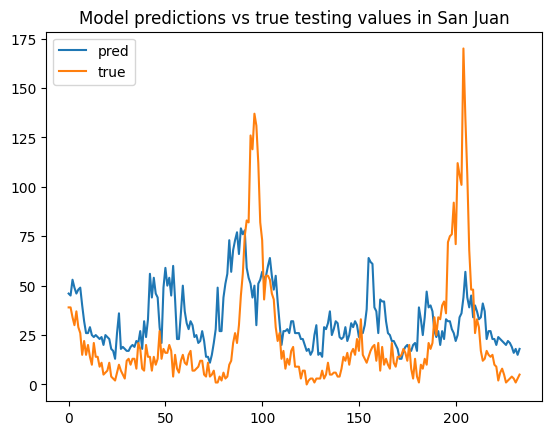

In [877]:
# plotting predictions vs testing values for San Juan
plt.plot(sj_test_pred, label='pred')
plt.plot(sj_y_test.values, label='true')
plt.legend()
plt.title('Model predictions vs true testing values in San Juan')
plt.show;

In [878]:
#Making predictions on training and testing data for Iquitos

iq_test_pred = iq_rf_model.predict(iq_X_test).astype(int)
iq_train_pred = iq_rf_model.predict(iq_X_train).astype(int)

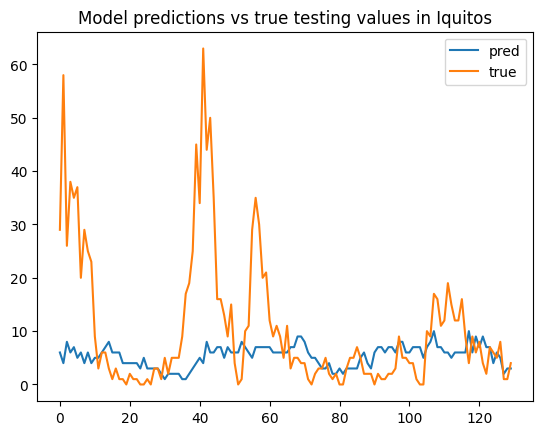

In [879]:
# plotting predictions vs testing values for Iquitos
plt.plot(iq_test_pred, label='pred')
plt.plot(iq_y_test.values, label='true')
plt.legend()
plt.title('Model predictions vs true testing values in Iquitos')
plt.show;

In [880]:
# Get training and testing metrics to check for overfitting
sj_rf_metrics = reg_metrics(sj_y_train, sj_train_pred, sj_y_test, sj_test_pred,'San Juan rf')
iq_rf_metrics = reg_metrics(iq_y_train, iq_train_pred, iq_y_test, iq_test_pred,'Iquitos rf')

sj_rf_metrics.T, iq_rf_metrics.T

(San Juan rf          0
 test_mae     21.572650
 train_mae    19.266382,
 Iquitos rf         0
 test_mae    8.061538
 train_mae   3.910256)

looks like some slight overfitting is happening for Iquitos and for San Juan the model is underfitting.

In [881]:
#concatenating training and testing predictions and values
iq_total_pred = np.hstack((iq_train_pred,iq_test_pred))
iq_true_values = np.hstack((iq_y_train.values,iq_y_test.values))

sj_total_pred = np.hstack((sj_train_pred,sj_test_pred))
sj_true_values = np.hstack((sj_y_train.values,sj_y_test.values))

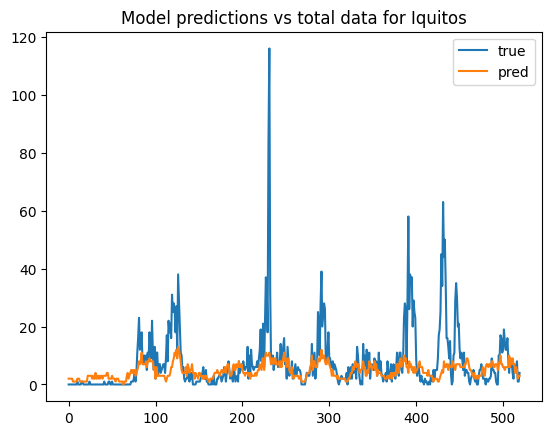

In [882]:
plt.plot(iq_true_values, label='true')
plt.plot(iq_total_pred, label='pred')
plt.legend()
plt.title('Model predictions vs total data for Iquitos')
plt.show;

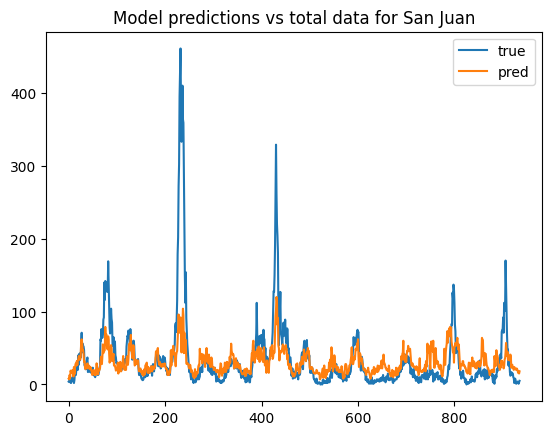

In [883]:
plt.plot(sj_true_values, label='true')
plt.plot(sj_total_pred, label='pred')
plt.legend()
plt.title('Model predictions vs total data for San Juan')
plt.show;

The model is able to detect the overall trends, but does not do a good job at predicting the peaks. We can use the peak boosting function with a calculus method and scaling method to boost the peaks.

In [886]:
def peakBoost(array, scalar, mixed=None):
    #Take derivative of array
    deriv = np.gradient(array)
    #Scale derivative
    new_deriv = deriv * scalar
    #Integrate the new derivative starting from 0
    integral = cumtrapz(new_deriv, initial=0)
    length = range(len(array))
    #Add intercept to match initial range
    boosted = [x+array[0] for x in integral]
    
    #Option ways to put floors on the output
    if mixed == 'max':
        out = [max(boosted[i], array[i]) for i in length]
    elif mixed == 'pos':
        out = [max(boosted[i], 0) for i in length]
    else:
        out = boosted
    
    arr = np.array([int(i) for i in out])
    
    Ser1 = pd.Series(arr)
    
    quantile_value = Ser1.quantile(q=0.99)
    print(quantile_value)
    
    for k,v in Ser1.items():
        if (v > quantile_value):
            Ser1[k] = Ser1[k]*2
    
    return np.array(Ser1)

In [887]:
sj_boost = peakBoost(sj_total_pred, 1.5,'pos')
iq_boost = peakBoost(iq_total_pred, 2.5, 'max')

121.29999999999995
22.809999999999945


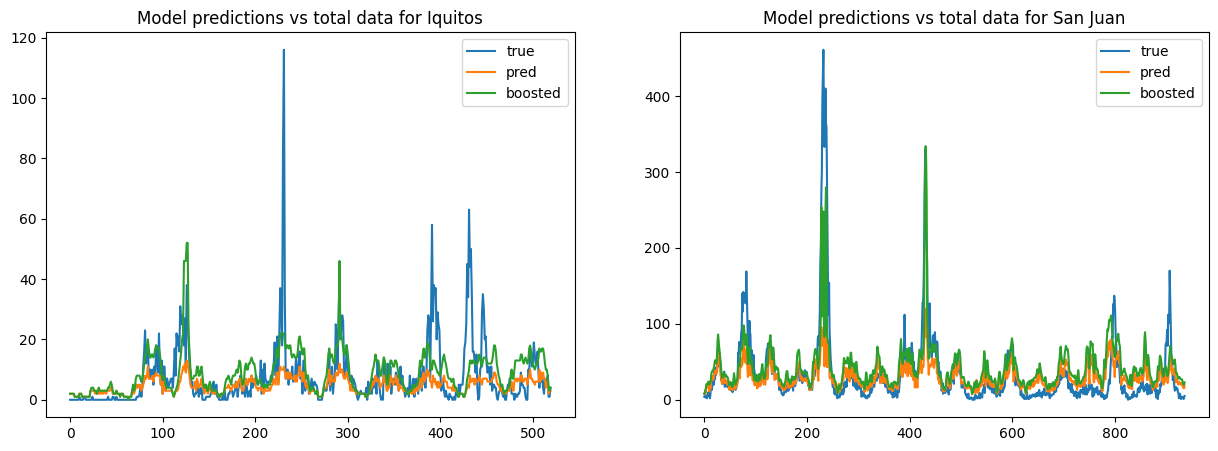

In [888]:
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(iq_true_values, label='true')
plt.plot(iq_total_pred, label='pred')
plt.plot(iq_boost, label='boosted')
plt.legend()
plt.title('Model predictions vs total data for Iquitos')
plt.show;
plt.show;
plt.legend()
plt.subplot(122)
plt.plot(sj_true_values, label='true')
plt.plot(sj_total_pred, label='pred')
plt.plot(sj_boost, label='boosted')
plt.legend()
plt.title('Model predictions vs total data for San Juan')
plt.show;
plt.show;

In [889]:
sj_train_boost = peakBoost(sj_train_pred, 1.5, 'pos')
sj_test_boost = peakBoost(sj_test_pred, 1.5, 'pos')
iq_train_boost = peakBoost(iq_train_pred, 2.9, 'max')
iq_test_boost = peakBoost(iq_test_pred, 2.9, 'max')

123.99000000000001
86.0
27.0
13.0


In [890]:
# Get training and testing metrics to check for overfitting
sj_rf_metrics = reg_metrics(sj_y_train, sj_train_boost, sj_y_test, sj_test_boost,'San Juan rf')
iq_rf_metrics = reg_metrics(iq_y_train, iq_train_boost, iq_y_test, iq_test_boost,'Iquitos rf')

sj_rf_metrics.T, iq_rf_metrics.T

(San Juan rf          0
 test_mae     18.564103
 train_mae    19.556980,
 Iquitos rf         0
 test_mae    8.238462
 train_mae   5.184615)

## Submission prediction

In [891]:
sj_rf_model.fit(sj_X, sj_y)

iq_rf_model.fit(iq_X, iq_y)

print('Training Complete!')

Training Complete!


In [892]:
testing_data = pd.read_csv('../raw_data/dengue_features_test.csv')

In [893]:
sj_test = testing_data[testing_data.city=='sj'].copy()
sj_test = preprocess(sj_test,train=False)
sj_test.shape

(260, 36)

In [894]:
iq_test = testing_data[testing_data.city=='iq'].copy()
iq_test = preprocess(iq_test,train=False)
iq_test.shape

(156, 36)

In [895]:
sj_pred = sj_rf_model.predict(sj_test).astype(int)
iq_pred = iq_rf_model.predict(iq_test).astype(int)
sj_boost = peakBoost(sj_pred, 1.5, 'pos')
iq_boost = peakBoost(iq_pred, 2.9, 'max')

97.0
19.899999999999977


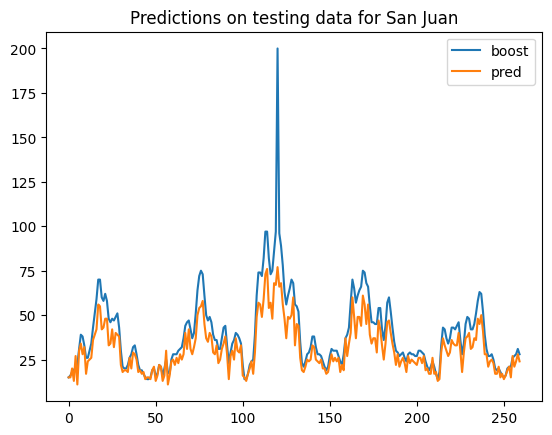

In [896]:
plt.plot(sj_boost, label='boost')
plt.plot(sj_pred, label='pred')
plt.legend()
plt.title('Predictions on testing data for San Juan')
plt.show;

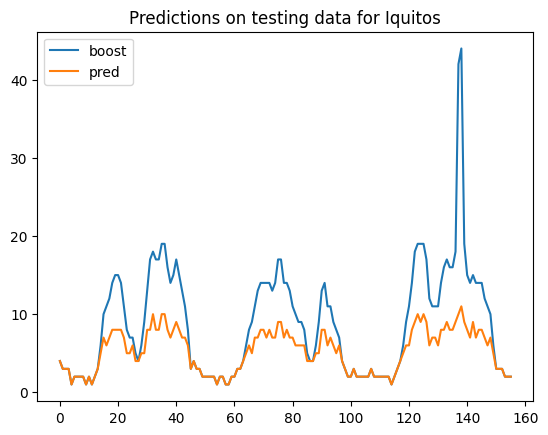

In [897]:
plt.plot(iq_boost, label='boost')
plt.plot(iq_pred, label='pred')
plt.legend()
plt.title('Predictions on testing data for Iquitos')
plt.show;

In [898]:
#Confirm no negative predictions
print(np.min(sj_boost))
print(np.min(iq_boost))

14
1


In [899]:
submission = pd.read_csv('../raw_data/submission_format.csv',
                            index_col=[0, 1, 2])

In [900]:
submission.total_cases = np.concatenate([sj_boost, iq_boost])
submission.to_csv("../submissions/rf_submission.csv")